### Updated version of Sky_background_compare, counting all 5 LSST filters 

In [30]:
%matplotlib inline
import lsst.sims.skybrightness as sb
import lsst.sims.photUtils.Bandpass as Bandpass
import os
import numpy as np
import matplotlib.pylab as plt
import healpy as hp
from lsst.sims.skybrightness.utils import robustRMS,ut2Mjd,mjd2ut
from lsst.sims.utils import calcLmstLast
from lsst.sims.photUtils import BandpassDict, Sed

In [3]:
compList = ['scatteredStar','lowerAtm','upperAtm','airglow','mergedSpec','twilight',
           'zodiacal','moon']

# Set up a grid of RA,Dec points to compute the sky model on
nside = 16
hpmap = np.zeros(hp.nside2npix(nside))
lat, ra = hp.pix2ang(nside, np.arange(hpmap.size))
dec = np.pi/2-lat

In [4]:
# Instatiate the sky model, setting some extra components to true so that everything loads.
sm = sb.SkyModel(lowerAtm=True, upperAtm=True,airglow=True, scatteredStar=True,mergedSpec=False)
sm.setRaDecMjd(ra,dec,49353.177645)

Lower Atm:    True
Airglow:      True
Upper Atm:    True
ScatteredStar True
mergedSpec:   False
zodiacal:     True
moon:         True
twilight:     True


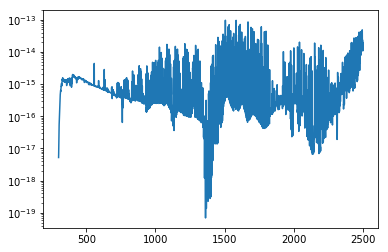

In [5]:
# Turn on all the components
# Note 'mergedSpec = lowerAtm + upperAtm + scatteredStar' set merged to 'False' to avoid over counting
for comp in compList: setattr(sm, comp, True)
# Turn on the scattered starlight
sm.mergedSpec= False
# Compute the spectra
sm._interpSky()
print('Lower Atm:   ',sm.lowerAtm)
print('Airglow:     ',sm.airglow)
print('Upper Atm:   ', sm.upperAtm)
print('ScatteredStar',sm.scatteredStar)
print('mergedSpec:  ',sm.mergedSpec)
print('zodiacal:    ', sm.zodiacal)
print('moon:        ',sm.moon)
print('twilight:    ',sm.twilight)
wave_all,spec_all = sm.returnWaveSpec()
plt.semilogy(wave_all,spec_all[-1]);

Lower Atm:    True
Airglow:      True
Upper Atm:    False
ScatteredStar True
mergedSpec:   False
zodiacal:     True
moon:         True
twilight:     True


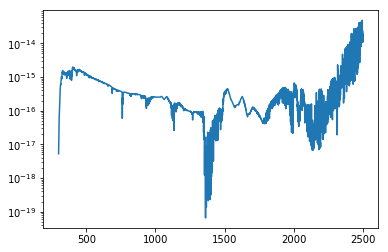

In [6]:

for comp in compList: setattr(sm, comp, True)

sm.mergedSpec= False
# Turn off upper atm
sm.upperAtm = False
# Compute the spectra
sm._interpSky()
print('Lower Atm:   ',sm.lowerAtm)
print('Airglow:     ',sm.airglow)
print('Upper Atm:   ', sm.upperAtm)
print('ScatteredStar',sm.scatteredStar)
print('mergedSpec:  ',sm.mergedSpec)
print('zodiacal:    ', sm.zodiacal)
print('moon:        ',sm.moon)
print('twilight:    ',sm.twilight)
wave_no_upper,spec_no_upper = sm.returnWaveSpec()
plt.semilogy(wave_no_upper,spec_no_upper[-1]);

In [38]:
def cal_frac (filter_name,plot = True):
    throughPath = os.getenv('LSST_THROUGHPUTS_BASELINE')
    bp = np.loadtxt(os.path.join(throughPath, 'total_%s.dat'%filter_name),dtype=list(zip(['wave','trans'],[float]*2 )))
    lsst_y = Bandpass()
    lsst_y.setBandpass(bp['wave'], bp['trans'],wavelen_step=0.2)
    wlen,inten = lsst_y.getBandpass()
    if plot == True:
        plt.title('LSST %s filter'%filter_name)
        plt.plot(wlen,inten,label = filter_name)
        plt.ylim(0,)
        plt.legend(loc = 'best')
    max_indx = np.where(inten != 0)[0][-1]
    min_indx = np.where(inten != 0)[0][0]
    #print(wlen[min_indx],wlen[max_indx])
    spec_indx_min = np.where(np.round(wave_all,1) == np.round(wlen[min_indx],1))[0][0]
    spec_indx_max = np.where(np.round(wave_all,1) == np.round(wlen[max_indx],1))[0][0]
    
    spec_inband = spec_all[-1][spec_indx_min:spec_indx_max]*inten[min_indx:max_indx]
    spec_inband_no_upper = spec_no_upper[-1][spec_indx_min:spec_indx_max]*inten[min_indx:max_indx]
    
    # Integrate flux overall wavelength
    inte = np.sum(spec_inband)
    noupper_inte = np.sum(spec_inband_no_upper)

    # Compute fraction of sky background without upper Atm
    print('Fraction of sky background w/o OH lines: %.2f'% (noupper_inte/inte*100),'%')
    return(wlen[min_indx:max_indx],spec_inband,spec_inband_no_upper)
    #print(wave_all[spec_indx_min:spec_indx_max])
    #print(wlen[min_indx:max_indx].shape)

Fraction of sky background w/o OH lines: 72.80 %
Fraction of sky background w/o OH lines: 93.42 %
Fraction of sky background w/o OH lines: 99.44 %
Fraction of sky background w/o OH lines: 50.36 %
Fraction of sky background w/o OH lines: 28.19 %


Text(0.5, 0, 'Wavelength[nm]')

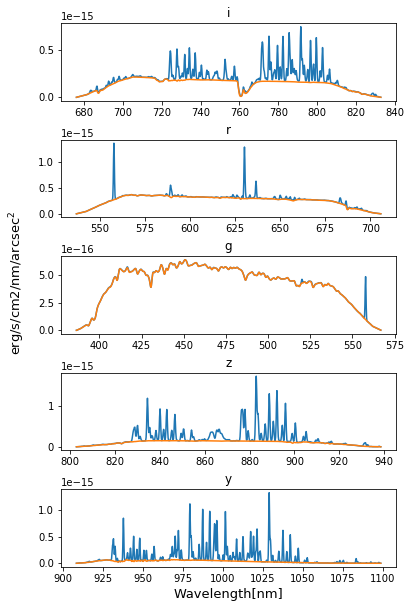

In [70]:
filter_list = ['i','r','g','z','y']
f,ax = plt.subplots(nrows=5,figsize = (6,10),sharex=False)
plt.subplots_adjust(hspace=0.5)
for i in range(len(filter_list)):
    wave,a,b = cal_frac(filter_name=filter_list[i],plot=False)
    ax[i].plot(wave,a)
    ax[i].plot(wave,b)
    ax[i].set_title(filter_list[i])
f.text(0,0.6,'erg/s/cm2/nm/arcsec$^2$',rotation = 'vertical',fontsize = 13)
ax[-1].set_xlabel('Wavelength[nm]',fontsize = 13)